In [1]:
# import libraries
try:
  # %tensorflow_version only exists in Colab.
  !pip install tf-nightly
except Exception:
  pass
try:
  import tensorflow as tf
except Exception:
  !pip install --upgrade tensorflow
import tensorflow as tf
import pandas as pd
from tensorflow import keras
!pip install tensorflow-datasets
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)


2.13.0


In this challenge, you need to create a machine learning model that will classify SMS messages as either "ham" or "spam". A "ham" message is a normal message sent by a friend. A "spam" message is an advertisement or a message sent by a company.

You should create a function called predict_message that takes a message string as an argument and returns a list. The first element in the list should be a number between zero and one that indicates the likeliness of "ham" (0) or "spam" (1). The second element in the list should be the word "ham" or "spam", depending on which is most likely.

In [2]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
!wget https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv

train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"

--2023-08-04 00:52:25--  https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 172.67.70.149, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 358233 (350K) [text/tab-separated-values]
Saving to: ‘train-data.tsv’

train-data.tsv      100%[===================>] 349.84K  --.-KB/s    in 0.07s   

2023-08-04 00:52:25 (5.15 MB/s) - ‘train-data.tsv’ saved [358233/358233]

--2023-08-04 00:52:25--  https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 172.67.70.149, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118774 (116K) [text/tab-separated-values]
Saving to: ‘valid-data.tsv’

valid-data.tsv      100%[==============

# Data Prepareation

In [3]:

from pandas.core.groupby import categorical
column_names = ['indicator', 'source']
train_data = pd.read_csv(train_file_path, delimiter = '\t', header = None,names= column_names)
train_data.dropna()
test_data = pd.read_csv(train_file_path, delimiter = '\t',header = None, names= column_names)
test_data.dropna()

,indicator,source
0,ham,ahhhh...just woken up!had a bad dream about u ...
1,ham,you can never do nothing
2,ham,"now u sound like manky scouse boy steve,like! ..."
3,ham,mum say we wan to go then go... then she can s...
4,ham,never y lei... i v lazy... got wat? dat day ü ...
...,...,...
4174,ham,just woke up. yeesh its late. but i didn't fal...
4175,ham,what do u reckon as need 2 arrange transport i...
4176,spam,free entry into our £250 weekly competition ju...
4177,spam,-pls stop bootydelious (32/f) is inviting you ...


In [4]:
train_dataset = train_data['source']
t_label = pd.get_dummies(train_data,columns=['indicator'],drop_first= True)
train_labels = t_label['indicator_spam']

In [5]:
test_dataset = test_data['source']
t_label = pd.get_dummies(test_data,columns=['indicator'],drop_first= True)
test_labels = t_label['indicator_spam']

# Data Processing

In [46]:
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Download the NLTK data
nltk.download('punkt')
nltk.download('stopwords')

def preprocess_email(email_text):
    # Convert text to lowercase
    email_text = email_text.lower()

    # Remove special characters and symbols
    email_text = re.sub(r'[^a-zA-Z0-9\s]', '', email_text)

    # Tokenize the text
    tokens = word_tokenize(email_text)


    # Join the tokens back into a cleaned text
    cleaned_text = ' '.join(tokens)

    return cleaned_text

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [47]:
train_email = [preprocess_email(email) for email in train_dataset]
test_email = [preprocess_email(email) for email in test_dataset]

In [71]:
#tokenizing and sequencing
VOCAB_SIZE = 88584

MAXLEN = 250
BATCH_SIZE = 64



from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences


def preprocess(cleaned_text):
  token = t = Tokenizer(num_words=MAXLEN)
  t.fit_on_texts(cleaned_text)
  sequence = t.texts_to_sequences(cleaned_text)
  sequence_matrix = pad_sequences(sequence, maxlen = MAXLEN)
  return sequence_matrix


array([[  0,   0,   0, ...,  42,  12,  15],
       [  0,   0,   0, ...,   3,  29,  30],
       [  0,   0,   0, ..., 106,   6,  45],
       ...,
       [  0,   0,   0, ..., 186,   1,  21],
       [  0,   0,   0, ...,  69,  87,   1],
       [  0,   0,   0, ...,  12,  36, 171]], dtype=int32)

# Model

In [89]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[MAXLEN]),
    tf.keras.layers.Embedding(VOCAB_SIZE, 32),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(
    loss='binary_crossentropy',
    optimizer='RMSprop',
    metrics=['accuracy']
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 250, 32)           2834688   
                                                                 
 lstm_5 (LSTM)               (None, 32)                8320      
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2843041 (10.85 MB)
Trainable params: 2843041 (10.85 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/10
27/27 [==============================] - 6s 135ms/step - loss: 0.4662 - accuracy: 0.8612 - val_loss: 0.3868 - val_accuracy: 0.8612
Epoch 2/10
27/27 [==============================] - 2s 56ms/step - loss: 0.3251 - accuracy: 0.8693 - val_loss: 0.3137 - val_accuracy: 0.8612
Epoch 3/10
27/27 [==============================] - 2s 70ms/step - loss: 0.2240 - accuracy: 0.9141 - val_loss: 0.1907 - val_accuracy: 0.9187
Epoch 4/10
27/27 [==============================] - 1s 29ms/step - loss: 0.1503 - accuracy: 0.9533 - val_loss: 0.1488 - val_accuracy: 0.9641
Epoch 5/10
27/27 [==============================] - 1s 25ms/step - loss: 0.1171 - accuracy: 0.9659 - val_loss: 0.1150 - val_accuracy: 0.9653
Epoch 6/10
27/27 [==============================] - 0s 18ms/step - loss: 0.0999 - accuracy: 0.9719 - val_loss: 0.1416 - val_accuracy: 0.9593


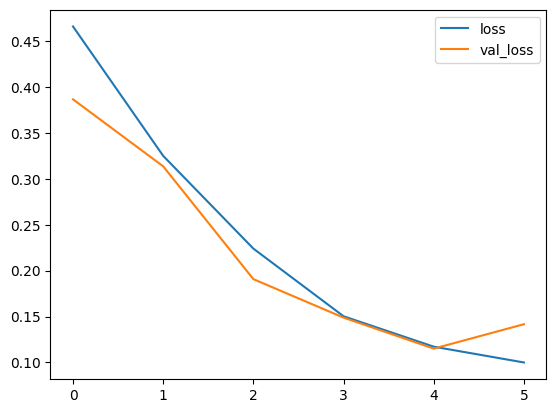

In [90]:
fitting = model.fit(preprocess(train_email), train_labels,
              batch_size=128, epochs=10,
              validation_split=0.2,
              callbacks=[tf.keras.callbacks.EarlyStopping(
                  monitor='val_loss', min_delta=0.0001)])

plt.plot(fitting.history['loss'], label='loss')
plt.plot(fitting.history['val_loss'], label='val_loss')
plt.legend()

In [91]:

def predict_message(pred_text):

    clean_text = preprocess_email(pred_text)
    sequence  = t.texts_to_sequences([clean_text])
    sequence_matrix  = pad_sequences(sequence, maxlen = MAXLEN)

    ps = model.predict(sequence_matrix)
    print(ps)
    p = ps[0][0]
    return [p, "ham" if p <0.5 else "spam"]

pred_text = "how are you doing today?"

prediction = predict_message(pred_text)
print(prediction)


1/1 [==============================] - 1s 506ms/step
[[0.01675568]]
[0.016755683, 'ham']


In [92]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()


1/1 [==============================] - 0s 20ms/step
[[0.01675568]]
1/1 [==============================] - 0s 25ms/step
[[0.7159211]]
1/1 [==============================] - 0s 22ms/step
[[0.00691862]]
1/1 [==============================] - 0s 22ms/step
[[0.8834278]]
1/1 [==============================] - 0s 21ms/step
[[0.9139313]]
1/1 [==============================] - 0s 23ms/step
[[0.00829683]]
1/1 [==============================] - 0s 26ms/step
[[0.04357992]]
You passed the challenge. Great job!
